In [168]:
import os
import numpy as np
from tqdm.notebook import tqdm
import re
import pandas as pd
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec as w2v
import matplotlib.pyplot as plt

In [169]:
# constants
BASE_DIR = r'C:\Users\Silen\Documents\Flickr8k'

# hyper parameters
NUM_EPOCHS = 30
BATCH_SIZE = 64
LEARNING_RATE = 0.0003

In [170]:
#getting just the caption information from the file
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [171]:
image_dict = {}

for line in tqdm(captions_doc.split('\n')):
    #tokens are formatted as "{image_id},{caption}"
    tokens = line.split(',')
    #tokens are now formatted as "{image_id}", "{caption}"
    image_id, caption = tokens[0], tokens[1:]
    #image_id is formatted as {id}.jpg
    #remove .jpg from the {id}
    image_id = image_id.split('.')[0]
    #caption is currently a list
    #convert caption from list to string
    caption = ' '.join(caption)
    #creates an index in the dict for image if not already there
    if image_id not in image_dict:
        image_dict[image_id] = []
    #connects all the captions to their respective images in one dict
    image_dict[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [172]:
def cleanText(image_dict):
    for key, captions in image_dict.items():
        for i in range(len(captions)):
            #load one caption at a time
            caption=captions[i]
            #lower case the whole string
            caption=caption.lower()
            #remove extra space
            caption=re.sub('\s\s+', ' ', caption)
            #get rid of any special characters or numbers
            caption=re.sub('[^A-Za-z\s]', '', caption)
            #add begining and ending tags and get rid of one character words
            # caption='<start> ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' <end>'
            #add caption back into list
            captions[i]=caption


In [173]:
#before preprocessing
image_dict['1015118661_980735411b']

['A boy smiles in front of a stony wall in a city .',
 'A little boy is standing on the street while a man in overalls is working on a stone wall .',
 'A young boy runs aross the street .',
 'A young child is walking on a stone paved street with a metal pole and a man behind him .',
 'Smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him .']

In [174]:
data = image_dict['1015118661_980735411b']
data.sort(key=lambda x: len(x), reverse=True)
data

['Smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him .',
 'A little boy is standing on the street while a man in overalls is working on a stone wall .',
 'A young child is walking on a stone paved street with a metal pole and a man behind him .',
 'A boy smiles in front of a stony wall in a city .',
 'A young boy runs aross the street .']

In [175]:
cleanText(image_dict)
#after prepossing
image_dict['1015118661_980735411b']

['smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him ',
 'a little boy is standing on the street while a man in overalls is working on a stone wall ',
 'a young child is walking on a stone paved street with a metal pole and a man behind him ',
 'a boy smiles in front of a stony wall in a city ',
 'a young boy runs aross the street ']

In [176]:
# nltk.download('stopwords')
sw = stopwords.words('english')

In [177]:
def tokenize(clean_image_dict):
    # gather all captions in one list
    all_captions = []
    for i in clean_image_dict:
        for caption in clean_image_dict[i]:
            all_captions.append(caption)
    all_captions = [word_tokenize(caption) for caption in all_captions] #list of all captions

    # remove stopwords
    filtered_captions = []
    for caption in all_captions:
        original = caption
        # removes stopword when detected in line
        # caption = [w for w in caption if w not in sw]
        # if the whole line was deleted the original line is used instead
        if len(caption) < 1:
            caption = original
        filtered_captions.append(caption)
    # creates word2vec keyedvector to store the vocabulary
    # uses skip-gram as the training algorithm
    # with a window of 3
    w = w2v(
        filtered_captions,
        vector_size=256,
        min_count=1,
        sg=1
    )
    return w


tokenized_captions = tokenize(image_dict)
vocab = list(tokenized_captions.wv.index_to_key)

In [178]:
image_ids = list(image_dict.keys())
for i in range(image_ids.count("")):
    image_ids.remove("")
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]
print(f'train size: {len(train)}')
print(f' test size: {len(test)}')

train size: 7281
 test size: 810


In [179]:
import torch
from torch import nonzero
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchsummary import summary
from PIL import Image

In [180]:
#device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [181]:
class CustomImageDataset(Dataset):
    def __init__(self, root, image_dict, image_ids, vocab) -> None:
        self.image_dict = image_dict
        self.image_ids = image_ids
        self.root = root
        self.vocab = vocab
        self.transform = transforms.Compose(
            [transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
        )
    def choose(self):
        return self[np.random.randint(len(self))] 
    def __len__(self):
        return len(self.image_ids)
    def __getitem__(self, index):
        img_path = os.path.join(self.root, 'Images', self.image_ids[index] + '.jpg')
        image = Image.open(img_path).convert('RGB')
        target = []
        caption = image_dict[image_ids[index]][0].split()
        target.extend([vocab.index(cap) for cap in caption])
        target = torch.Tensor(target).long()
        return image, target, caption
    def collate_fn(self, data):
        #TODO: write this
        data.sort(key=lambda x: len(x[1]), reverse=True)
        images, targets, captions = zip(*data)
        images = torch.stack([self.transform(image) for image in images], 0)
        lengths = [len(tar) for tar in targets]
        if 0 in lengths: 
            print(f'length = 0, 0-length strings: {targets}, lengths: {lengths}')
            # _tars = [tar for tar in targets]
            # for i in _tars:
            #     print(i)
            #     print(*[vocab[j.item()] for j in i])
            _tars = list(targets)
            _tars[-1] = torch.zeros(1)
            targets = tuple(_tars)
            
        _targets = torch.zeros(len(captions), max(lengths)).long()
        for i, tar in enumerate(targets):
            end = lengths[i]
            _targets[i, :end] = tar[:end]
        return images.to(device), _targets.to(device), torch.tensor(lengths).long().to(device)
       

In [182]:
train_ds = CustomImageDataset(root=BASE_DIR, image_dict=image_dict, image_ids=train, vocab=vocab)
test_ds = CustomImageDataset(root=BASE_DIR, image_dict=image_dict, image_ids=test, vocab=vocab)

In [183]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_ds.collate_fn)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=test_ds.collate_fn)
print(len(train_ds))

7281


In [184]:
# loads the word vectors into a float tensor to pretrain a word embedding layer
weight = torch.FloatTensor(tokenized_captions.wv.vectors)
embedding = nn.Embedding.from_pretrained(weight)

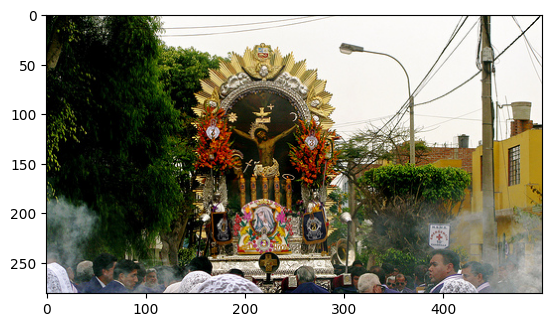

label: ['a', 'float', 'depicting', 'religious', 'imagery']


In [185]:
# display image and label
#train_features, train_labels = next(iter(train_dl))
train_features, train_labels, train_captions = train_ds.choose()
img = train_features
# label = train_labels[0]
label = [vocab[i] for i in train_labels]
plt.imshow(img)
plt.show()
print(f'label: {label}')

In [186]:
class EncoderCNN1(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN1, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)         # 6x220x220
        self.pool = nn.MaxPool2d(2, 2)                      # 6x110x110
        self.conv2 = nn.Conv2d(6, 16, 5)                    # 16x106x106 ; after last pool: 16x52x52
        self.fc1 = nn.Linear(44944, 256, device=device)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
    def forward(self, x):
        with torch.no_grad():
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn(x)
        return x

In [187]:
model = EncoderCNN1(256).to(device=device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 220, 220]             456
         MaxPool2d-2          [-1, 6, 110, 110]               0
            Conv2d-3         [-1, 16, 106, 106]           2,416
         MaxPool2d-4           [-1, 16, 53, 53]               0
            Linear-5                  [-1, 256]      11,505,920
       BatchNorm1d-6                  [-1, 256]             512
Total params: 11,509,304
Trainable params: 11,509,304
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 4.49
Params size (MB): 43.90
Estimated Total Size (MB): 48.97
----------------------------------------------------------------


In [188]:
class EncoderCNN2(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)         # 32x220x220
        self.pool = nn.MaxPool2d(2, 2)                       # 32x110x110
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)        # 64x106x106 ; after last pool: 64x53x53
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(64*53*53, 256, device=device)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
    def forward(self, x):
        with torch.no_grad():
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
        x = self.flat(x)
        x = self.fc1(x)
        x = self.bn(x)
        return x

In [189]:
model = EncoderCNN2(256).to(device=device)
summary(model, (3, 224, 224), BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 32, 220, 220]           2,432
         MaxPool2d-2         [64, 32, 110, 110]               0
            Conv2d-3         [64, 64, 106, 106]          51,264
         MaxPool2d-4           [64, 64, 53, 53]               0
           Flatten-5               [64, 179776]               0
            Linear-6                  [64, 256]      46,022,912
       BatchNorm1d-7                  [64, 256]             512
Total params: 46,077,120
Trainable params: 46,077,120
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 36.75
Forward/backward pass size (MB): 1472.25
Params size (MB): 175.77
Estimated Total Size (MB): 1684.77
----------------------------------------------------------------


In [190]:
from torchvision.models import vgg16, VGG16_Weights

In [191]:
class EncoderCNN3(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN3, embed_size).__init__()
        self.weights = VGG16_Weights.DEFAULT
        self.model = vgg16(weights=self.weights)
    def forward(self, x):
        pass

In [192]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, weight, max_seq_length=15):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embed = nn.Embedding.from_pretrained(weight)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        self.softmax = nn.LogSoftmax(dim=1)
    def init_hidden(self,):
        return(torch.zeros(1, self.hidden_size))
    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths.cpu(), batch_first=True)
        packed = packed.to(device)
        outputs, _ = self.lstm(packed)
        outputs = self.linear(outputs[0])
        return outputs
    def predict(self, features, states=None):
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq_length):
            hidden, states = self.lstm(inputs, states)
            outputs = self.linear(hidden.squeeze(1))
            _, predicted = outputs.max(1)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)
            inputs = inputs.unsqueeze(1)
        sampled_ids = torch.stack(sampled_ids, 1)
        sentences = []
        for sampled_id in sampled_ids:
            sampled_id = sampled_id.cpu().numpy()
            sampled_caption = []
            for word_id in sampled_id:
                word = vocab[word_id]
                sampled_caption.append(word)
                if word == '<end>':
                    break
                print(sampled_caption)
            sentence = ' '.join(sampled_caption)
            sentences.append(sentence)
            return sentences

In [193]:
def train_batch(data, encoder, decoder, optimizer, criterion):
    if torch.cuda.is_available():
        encoder.to(device)
        decoder.to(device)
        criterion.to(device)
    optimizer.zero_grad()
    encoder.train()
    decoder.train()
    # TODO: Need dataloader to load batches at a time
    images, captions, lengths = data
    images = images.to(device)
    captions = captions.to(device)
    targets = pack_padded_sequence(captions, lengths.cpu(), batch_first=True)[0]
    features = encoder(images)
    outputs = decoder(features, captions, lengths)
    # print(f'outputs type: {type(outputs)} \ntargets type: {type(targets)}')
    loss = criterion(outputs, targets)
    # decoder.zero_grad()
    # encoder.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [194]:
@torch.no_grad()
def test_batch(data, encoder, decoder, criterion):
    encoder.eval()
    decoder.eval()
    images, captions, lengths = data
    images = images.to(device)
    captions = captions.to(device)
    targets = pack_padded_sequence(captions, lengths.cpu(), batch_first=True)[0]
    features = encoder(images)
    outputs = decoder(features, captions, lengths)
    loss = criterion(outputs, targets)
    return loss

In [195]:
encoder = EncoderCNN2(256).to(device)
decoder = DecoderRNN(256, 512, len(vocab), 1, weight)
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.fc1.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.AdamW(params, lr=LEARNING_RATE)

In [196]:
for epoch in range(NUM_EPOCHS):
    with tqdm(train_dl, unit='batch') as tepoch:
        for data in tepoch:
            tepoch.set_description(f'Training Epoch {epoch+1}')
            train_loss = train_batch(data, encoder, decoder, optimizer, criterion)
    with tqdm(test_dl, unit='batch') as tepoch:
        for data in tepoch:
            tepoch.set_description(f'Testing  Epoch {epoch+1}')
            test_loss = test_batch(data, encoder, decoder, criterion)

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/114 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

In [197]:
# cell above does this in a much cleaner way

# for epoch in range(num_epochs):
#     N = len(train_dl)
#     for i, data in tqdm(enumerate(train_dl), ):
#         # print(f'training iteration: {i+1}/{N}')
#         if i == N: 
#             print(data)
#             break
#         train_loss = train_batch(data, encoder, decoder, optimizer, criterion)
#     print(train_loss)
#     N = len(test_dl)
#     for i, data in enumerate(test_dl):
#         # print(f'testing iteration: {i+1}/{N}')
#         test_loss = test_batch(data, encoder, decoder, criterion)
#     print(epoch)
    

In [198]:
def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    if transform is not None:
        tfm_image = transform(image)[None]
    return image, tfm_image

In [199]:
def load_image_and_predict(image_path):
    transform = transforms.Compose(
            [transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
        )
    org_image, tfm_image = load_image(image_path, transform)
    image_tensor = tfm_image.to(device)
    encoder.eval()
    decoder.eval()
    feature = encoder(image_tensor)
    sentence = decoder.predict(feature)[0]
    plt.imshow(org_image)
    plt.title(sentence)
    plt.show()
    return sentence

['smiling']
['smiling', 'in']
['smiling', 'in', 'a']
['smiling', 'in', 'a', 'white']
['smiling', 'in', 'a', 'white', 'shirt']
['smiling', 'in', 'a', 'white', 'shirt', 'and']
['smiling', 'in', 'a', 'white', 'shirt', 'and', 'a']
['smiling', 'in', 'a', 'white', 'shirt', 'and', 'a', 'black']
['smiling', 'in', 'a', 'white', 'shirt', 'and', 'a', 'black', 'shirt']
['smiling', 'in', 'a', 'white', 'shirt', 'and', 'a', 'black', 'shirt', 'is']
['smiling', 'in', 'a', 'white', 'shirt', 'and', 'a', 'black', 'shirt', 'is', 'standing']
['smiling', 'in', 'a', 'white', 'shirt', 'and', 'a', 'black', 'shirt', 'is', 'standing', 'in']
['smiling', 'in', 'a', 'white', 'shirt', 'and', 'a', 'black', 'shirt', 'is', 'standing', 'in', 'the']
['smiling', 'in', 'a', 'white', 'shirt', 'and', 'a', 'black', 'shirt', 'is', 'standing', 'in', 'the', 'background']
['smiling', 'in', 'a', 'white', 'shirt', 'and', 'a', 'black', 'shirt', 'is', 'standing', 'in', 'the', 'background', 'of']


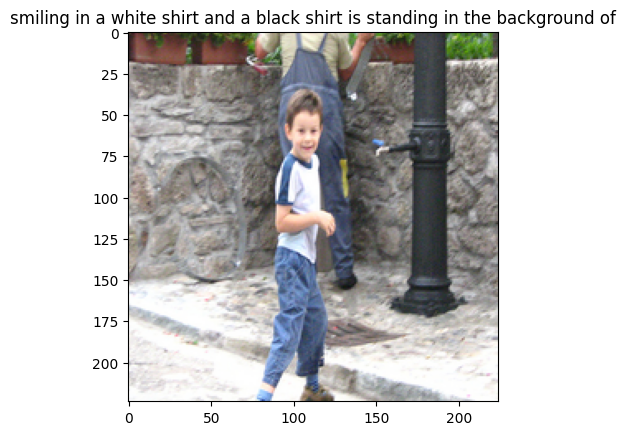

'smiling in a white shirt and a black shirt is standing in the background of'

In [200]:
image_path = os.path.join(BASE_DIR, 'Images', '1015118661_980735411b' + '.jpg')
load_image_and_predict(image_path)